<a href="https://colab.research.google.com/github/chanmeee/DL_papers_study/blob/main/Faster_R_CNN_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch를 이용한 Faster R-CNN 논문 구현
- 논문 제목: Shaoqing Ren et al. (2016), Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks
- 참고자료
  -  How FasterRCNN works and step-by-step PyTorch implementation - https://youtu.be/4yOcsWg-7g8 
  - Pytorch로 구현한 Faster R-CNN 모델 - https://herbwood.tistory.com/11 

---
### 들어가며 (Intro)

#### 1) 모델 설명
- Faster R-CNN은 여러 코드 구현체가 있었지만, 살펴볼 코드가 RPN 내부에서 동작하는 여러 과정들을 직관적으로 잘 보여준 것 같아서 선정함
- 진행과정 

    <img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FQhStI%2FbtqQ1Nvi3UG%2F1cZ9NeoiLUXfbK0VblaX80%2Fimg.png" width=600>

#### 2) 데이터 설명 
<img  src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbOrYQh%2FbtqReRjLDKr%2Fevbv39kMgTcmqCwN94vXzK%2Fimg.png" width=250>

- 입력 이미지로 얼룩말 이미지 사용 
- 편의를 위해 원본 이미지를 800x800 크기로 resize


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 라이브러리 불러오기 (Importing Libraries)

In [24]:
# PyTorch
import torch
import torch.nn as nn 
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

# 이미지 그리기 
import cv2 
from PIL import Image  
import matplotlib.pyplot as plt
%matplotlib inline

import os
import numpy as np
import time 

# GPU 사용
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('[GPU 이름]', device, '| [GPU 성능]',torch.cuda.get_device_name(0))

[GPU 이름] cuda:0 | [GPU 성능] Tesla P100-PCIE-16GB


### 0. 데이터 전처리  (Data Preprocessing)
- 이 예제에서는 1개의 이미지만 이용 (BATCH_SIZE = 1)

#### 1) 이미지 시각화  (Visualize image and bounding boxes)

(1333, 2000, 3)


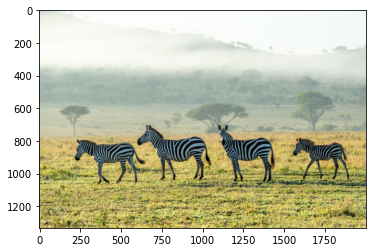

In [25]:
img0 = cv2.imread('/content/drive/MyDrive/딥러닝 스터디/2 23/zebras.jpg')
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB) # COLOR_BGR2RGB: 컬러 사진을 OpenCV에서는 BGR 순서로 저장하는데, matplotlib에서는 RGB 순서로 저장합니다. 따라서 BGR을 RGB로 바꾸어 주어야만 사진이 제대로 표시됨
print(img0.shape)
plt.imshow(img0)
plt.show()

In [26]:
# object information : a set of bounding boxes [x1, y1, x2, y2] 
# and their labels
bbox0 = np.array([[223, 782, 623, 1074], [597, 695, 1038, 1050], 
                  [1088, 699, 1452, 1057], [1544, 771, 1914, 1063]]) 
labels = np.array([1, 1, 1, 1]) # 0: 배경, 1: zebra

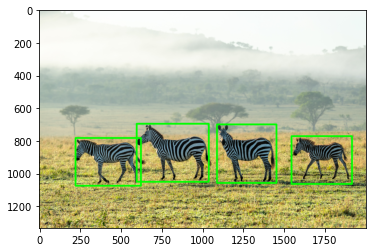

In [27]:
# display bounding box and labels

img0_clone = np.copy(img0)
for i in range(len(bbox0)):
    cv2.rectangle(img0_clone, (bbox0[i][0], bbox0[i][1]), 
                              (bbox0[i][2], bbox0[i][3]),
                 color=(0, 255, 0), thickness=10)
plt.imshow(img0_clone)
plt.show()

#### 2) 이미지 크기 변환 (Resize image and bounding boxes)

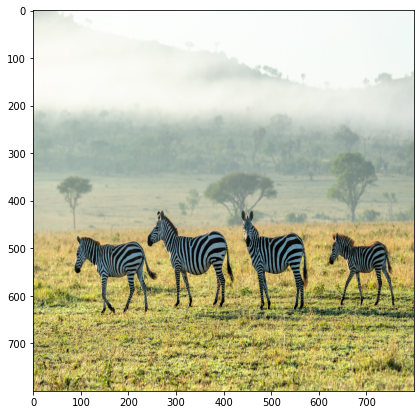

In [28]:
# 입력 이미지를 (800 * 800) 크기로 변환

img = cv2.resize(img0, dsize=(800, 800), interpolation=cv2.INTER_CUBIC)
plt.figure(figsize=(7, 7))
plt.imshow(img)
plt.show()

0.4 0.6001500375093773
[[ 89 469 249 644]
 [238 417 415 630]
 [435 419 580 634]
 [617 462 765 637]]


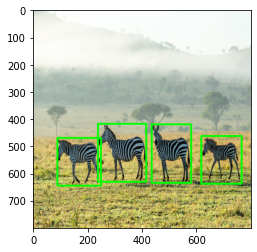

In [29]:
# 초록색 박스도 변경
# 원본 이미지 사이즈 : (1333, 2000)

Wratio = 800/img0.shape[1]
Hratio = 800/img0.shape[0]

print(Wratio, Hratio)

ratioList = [Wratio, Hratio, Wratio, Hratio]
bbox = []

for box in bbox0:
    box = [int(a*b) for a, b in zip(box, ratioList)]
    bbox.append(box)
    
bbox = np.array(bbox)
print(bbox)

img_clone = np.copy(img)
for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), color=(0, 255, 0), thickness=5)
plt.imshow(img_clone)
plt.show()

### 1. VGG16으로 Feature extractor 정의 (Feature extractor by pre-trained VGG16)
- 원본 이미지에 대하여 feature extraction을 수행할 pre-trained VGG16 모델을 정의
- 전체 모델에서 sub-sampling ratio(1/16)에 맞게 50x50 크기가 되는 layer까지만 feature extractor로 사용

  <방법>
  1. 원본 이미지와 크기가 같은 800x800 크기의 dummy 배열을 입력하여 50x50 크기의 feature map을 출력하는 layer를 찾는다.
  2. `faster_rcnn_feature_extractor` 변수에 전체 모델에서 해당 layer까지만 저장
  3. 원본 이미지를 `faster_rcnn_feature_extractor`에 입력하여 50x50x512 크기의 feature map을 얻는다.


#### 1) 사전학습된 VGG16 모델 불러오기 (Load pretrained VGG16)

In [31]:
# VGG16의 feature extraction을 출력

model = models.vgg16(pretrained=True).to(device) # GPU를 이용해 미리 학습된 VGG16 모델을 불러온다
features = list(model.features)
print(len(features))
print(features)

31
[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1

#### 2) 필요한 레이어만 수집 (Only collect required layers)


In [37]:
# output feature map 크기 (W, H) < 50 인 레이어만 모으기 

dummy_img = torch.zeros((1, 3, 800, 800)).float() # 리사이징한 zebras 이미지와 동일한 크기의 test image array를 생성, (batch_size=1, channel=3, width=800, height=800)
print(dummy_img.shape)

req_features = []
output = dummy_img.clone().to(device)

for feature in features:
    output = feature(output)
#     print(output.size()) => torch.Size([batch_size, channel, width, height])
    if output.size()[2] < 800//16: # 800/16=50
        break
    req_features.append(feature)
    out_channels = output.size()[1]
    
print('req_features의 길이:', len(req_features))
print('req_features의 내용:', req_features)
print(out_channels)

torch.Size([1, 3, 800, 800])
req_features의 길이: 30
req_features의 내용: [Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True

In [38]:
# 필요한 레이어 리스트(req_features)를 Seqeuntial module로 변환 
## 모델을 생성할 수 있도록 
faster_rcnn_feature_extractor = nn.Sequential(*req_features)

In [42]:
# 입력 이미지의 결과값을 feature extractor로 전달

transform = transforms.Compose([transforms.ToTensor()]) # transform: Tensor로 변환하는 함수
imgTensor = transform(img).to(device)
imgTensor = imgTensor.unsqueeze(0)  # 0번째 위치에 1인 차원이 추가, Batch_size를 의미 
output_map = faster_rcnn_feature_extractor(imgTensor) # feature map 얻기 

print(output_map.size())

torch.Size([1, 512, 50, 50])


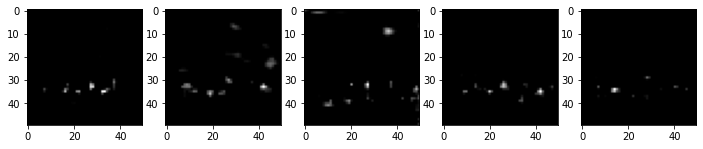

In [43]:
# (50*50*512)짜리 feature maps에서 첫 5개의 채널을 시각화

imgArray = output_map.data.cpu().numpy().squeeze(0) 
fig = plt.figure(figsize=(12, 4))
figNo = 1

for i in range(5):
    fig.add_subplot(1, 5, figNo)
    plt.imshow(imgArray[i], cmap='gray')
    figNo += 1
    
plt.show()

### 2. Anchor generation layer 생성 (Generate Anchor generation layer)

<img src = "https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FCLBD9%2FbtqQ7TJNtmq%2FMlK8x4P8mil1CDWTudtMf0%2Fimg.png"  width=175>
<img src = "https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FYTvfn%2FbtqRcG3Xv1r%2Fa3oMRl1UdzoGGD0fwXuSV1%2Fimg.png"  width=175>
<img src = "https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FzHQbH%2FbtqRawHhvHL%2Fq5o0dnG6OTW5U34NWHcWy1%2Fimg.png" width=350>

- **Anchor generation layer**에서는 anchor box를 생성하는 역할을 한다.
- 이미지 크기 = (800x800), sub-sampling ratio = 1/16 ⇒ 따라서 sub-sampled feature map 크기 = 800 x 1/16 = 50
- 따라서 총 22500(=50x50)개의 anchor box를 생성해야 한다.
  
  <방법>
  1. 16 x 16 간격의 grid마다 anchor를 생성
  2. anchor 기준으로 서로 다른 scale과 aspect ratio를 가지는 9개의 anchor box를 생성 
  3. anchor box 변수에 전체 anchor box의 좌표 (x1, y1, x2, y2)를 저장 (이렇게 생성된 anchor_boxes 변수의 크기는 (22500, 4))

    <img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FshfXO%2FbtqXLeuge7A%2FEf0bNLZbmjvkDXysqlTMy0%2Fimg.png" width=500>

#### 1) Anchors 생성

In [44]:
# sub-sampling rate = 1/16
# image size : 800x800
# sub-sampled feature map size : 800 x 1/16 = 50
# 50 x 50 = 2500 anchors and each anchor generate 9 anchor boxes
# total anchor boxes = 50 x 50 x 9 = 22500
# x,y intervals to generate anchor box center

feature_size = 800 // 16  # 50
ctr_x = np.arange(16, (feature_size + 1) * 16, 16)
ctr_y = np.arange(16, (feature_size + 1) * 16, 16)
print(len(ctr_x))
print(ctr_x)

50
[ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]


In [45]:
# # coordinates of the 255 center points to generate anchor boxes

# index = 0
# ctr = np.zeros((2500, 2))

# for i in range(len(ctr_x)):
#     for j in range(len(ctr_y)):
#         ctr[index, 1] = ctr_x[i] - 8
#         ctr[index, 0] = ctr_y[j] - 8
#         index += 1

# # ctr => [[center x, center y], ...]
# print(ctr.shape)
# print(ctr[:10, :])

(2500, 2)
[[  8.   8.]
 [ 24.   8.]
 [ 40.   8.]
 [ 56.   8.]
 [ 72.   8.]
 [ 88.   8.]
 [104.   8.]
 [120.   8.]
 [136.   8.]
 [152.   8.]]


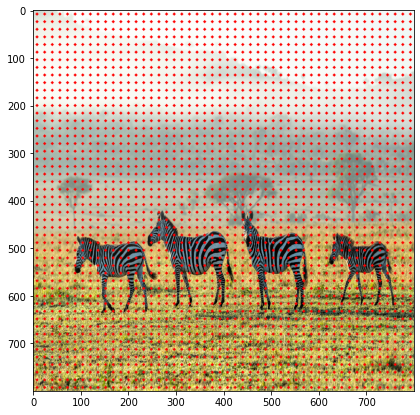

In [46]:
# display the 2500 anchors within image

img_clone2 = np.copy(img)
ctr_int = ctr.astype("int32")

plt.figure(figsize=(7, 7))
for i in range(ctr.shape[0]):
    cv2.circle(img_clone2, (ctr_int[i][0], ctr_int[i][1]),
              radius=1, color=(255, 0, 0), thickness=3)
plt.imshow(img_clone2)
plt.show()

#### 2) Generate Anchor boxes

In [47]:
# for each of the 2500 anchors, generate 9 anchor boxes
# 2500 x 9 = 22500 anchor boxes

ratios = [0.5, 1, 2]
scales = [8, 16, 32]
sub_sample = 16

anchor_boxes = np.zeros(((feature_size * feature_size * 9), 4))
index = 0

for c in ctr:                        # per anchors
    ctr_y, ctr_x = c
    for i in range(len(ratios)):     # per ratios
        for j in range(len(scales)): # per scales
            
            # anchor box height, width
            h = sub_sample * scales[j] * np.sqrt(ratios[i])
            w = sub_sample * scales[j] * np.sqrt(1./ ratios[i])
            
            # anchor box [x1, y1, x2, y2]
            anchor_boxes[index, 1] = ctr_y - h / 2.
            anchor_boxes[index, 0] = ctr_x - w / 2.
            anchor_boxes[index, 3] = ctr_y + h / 2.
            anchor_boxes[index, 2] = ctr_x + w / 2.
            index += 1
            
print(anchor_boxes.shape) 
print(anchor_boxes[:10, :])

(22500, 4)
[[ -82.50966799  -37.254834     98.50966799   53.254834  ]
 [-173.01933598  -82.50966799  189.01933598   98.50966799]
 [-354.03867197 -173.01933598  370.03867197  189.01933598]
 [ -56.          -56.           72.           72.        ]
 [-120.         -120.          136.          136.        ]
 [-248.         -248.          264.          264.        ]
 [ -37.254834    -82.50966799   53.254834     98.50966799]
 [ -82.50966799 -173.01933598   98.50966799  189.01933598]
 [-173.01933598 -354.03867197  189.01933598  370.03867197]
 [ -82.50966799  -21.254834     98.50966799   69.254834  ]]


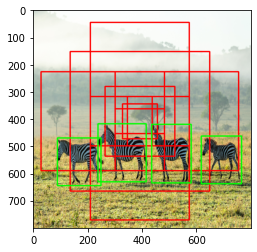

In [48]:
# display the anchor boxes of one anchor and the ground truth boxes

img_clone = np.copy(img)

# draw random anchor boxes
for i in range(11025, 11034):
    x1 = int(anchor_boxes[i][0])
    y1 = int(anchor_boxes[i][1])
    x2 = int(anchor_boxes[i][2])
    y2 = int(anchor_boxes[i][3])
    
    cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255, 0, 0),
                 thickness=3)

# draw ground truth boxes
for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), 
                             (bbox[i][2], bbox[i][3]),
                 color=(0, 255, 0), thickness=3)

plt.imshow(img_clone)
plt.show()

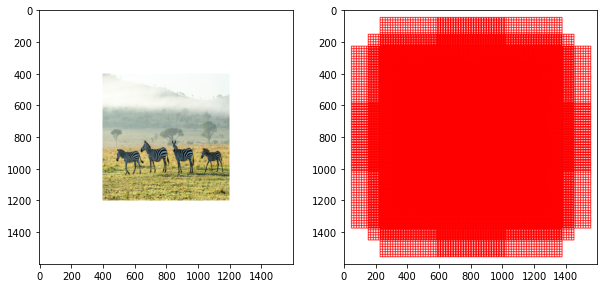

In [49]:
# draw all anchor boxes

# add paddings(can't draw anchor boxes out of image boundary)
img_clone3 = np.copy(img)
img_clone4 = cv2.copyMakeBorder(img_clone3,400,400,400,400,cv2.BORDER_CONSTANT, value=(255, 255, 255))
img_clone5 = np.copy(img_clone4)

for i in range(len(anchor_boxes)):
    x1 = int(anchor_boxes[i][0])
    y1 = int(anchor_boxes[i][1])
    x2 = int(anchor_boxes[i][2])
    y2 = int(anchor_boxes[i][3])
    
    cv2.rectangle(img_clone5, (x1+400, y1+400), (x2+400, y2+400), color=(255, 0, 0),
                 thickness=3)

plt.figure(figsize=(10, 10))
plt.subplot(121), plt.imshow(img_clone4)
plt.subplot(122), plt.imshow(img_clone5)
plt.show()

### 3. Anchor Target layer

- **Anchor Target layer**에서는 RPN을 학습시키기 위해 적절한 anchor box를 선택하는 작업을 수행한다. 

#### 1) Only choose anchor boxes inside the image
- 먼저 아래와 같이 이미지 경계(=800x800) 내부에 있는 anchor box만을 선택한다.

In [50]:
# ignore the cross-boundary anchor boxes
# valid anchor boxes with (x1, y1) > 0 and (x2, y2) <= 800

index_inside = np.where(
        (anchor_boxes[:, 0] >= 0) &
        (anchor_boxes[:, 1] >= 0) &
        (anchor_boxes[:, 2] <= 800) &
        (anchor_boxes[:, 3] <= 800))[0]

print(index_inside.shape)

# only 8940 anchor boxes are inside the boundary out of 22500
valid_anchor_boxes = anchor_boxes[index_inside]
print(valid_anchor_boxes.shape)

(8940,)
(8940, 4)


#### 2) Calculate IoUs
- 그 다음 전체 anchor box에 대하여 ground truth box와의 IoU 값을 구한다.
- **IoU(Intersection over Union)**란
  - object detector의 정확도를 측정하는데 이용되는 평가 지표 
  - ground-truth bounding boxes(testing set에서 object 위치를 labeling 한 것)과 prediceted bounding boxes (model이 출력한 object 위치 예측값)이 **얼마나 일치하는지**를 비교

  <img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FnEGR6%2FbtqSa9dWR4S%2FdjSXfCazQ46bySI2KKiar0%2Fimg.png" width=250>  <img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FwNXOK%2FbtqSpGVHmHc%2FKbsxRBSs6KymYB3PkEny21%2Fimg.png" width=250> <img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FTe2u5%2FbtqSmAOZAJd%2FPaLKF4IUrNqYIZbYCkyIjK%2Fimg.png" width=450> 

  - 참고 - https://deep-learning-study.tistory.com/402

- IoU 값이 
  - (0.7 이상인 anchor box) → positive sample
  - (0.3 미만인 anchor box) → negative sample로 저장

In [51]:
# calculate Iou of the valid anchor boxes
# since we have 8940 anchor boxes and 4 ground truth objects,
# we should get an array with (8940, 4) as the output
# [IoU with gt box1, IoU with gt box2, IoU with gt box3, IoU with gt box4]

ious = np.empty((len(valid_anchor_boxes),4), dtype=np.float32)
ious.fill(0)

# anchor boxes
for i, anchor_box in enumerate(valid_anchor_boxes):
    xa1, ya1, xa2, ya2 = anchor_box
    anchor_area = (xa2 - xa1) * (ya2 - ya1)
    
    # ground truth boxes
    for j, gt_box in enumerate(bbox):
        xb1, yb1, xb2, yb2 = gt_box
        box_area = (xb2 - xb1) * (yb2 - yb1)
        
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            inter_area = (inter_x2 - inter_x1) * (inter_y2 - inter_y1)
            iou = inter_area / (anchor_area + box_area - inter_area)
        else:
            iou = 0
        
        ious[i, j] = iou
        
print(ious.shape)
print(ious[8930:8940, :])

(8940, 4)
[[0.         0.         0.         0.37780452]
 [0.         0.         0.         0.33321926]
 [0.         0.         0.         0.29009855]
 [0.         0.         0.         0.24967977]
 [0.         0.         0.         0.2117167 ]
 [0.         0.         0.         0.17599213]
 [0.         0.         0.         0.14231375]
 [0.         0.         0.         0.11051063]
 [0.         0.         0.         0.08043041]
 [0.         0.         0.         0.05193678]]


#### 3) Sample positive/negative anchor boxes

In [52]:
# what anchor box has max ou with the ground truth box

gt_argmax_ious = ious.argmax(axis=0)
print(gt_argmax_ious)

gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
print(gt_max_ious)

gt_argmax_ious = np.where(ious == gt_max_ious)[0]
print(gt_argmax_ious)

[1008 2862 5935 8699]
[0.58514285 0.5752716  0.5255493  0.6325869 ]
[1008 1013 1018 1226 1232 1238 2862 2869 2876 3108 3115 3122 3336 3343
 3350 3354 3357 3361 3364 3368 3371 3377 3383 3389 3600 3607 3614 3846
 3853 3860 5935 5942 6164 6171 6178 6181 6185 6188 6192 6198 6427 6434
 8699 8703 8707]


In [53]:
# what ground truth bbox is associated with each anchor box

argmax_ious = ious.argmax(axis=1)
print(argmax_ious.shape)
print(argmax_ious)

max_ious = ious[np.arange(len(index_inside)), argmax_ious]
print(max_ious)

(8940,)
[0 0 0 ... 3 3 3]
[0.         0.         0.         ... 0.11051063 0.08043041 0.05193678]


In [54]:
# set the labels of 8940 valid anchor boxes to -1(ignore)

label = np.empty((len(index_inside),), dtype=np.int32)
label.fill(-1)
print(label.shape)

(8940,)


In [55]:
# use IoU to assign 1 (objects) to two kind of anchors
# a) the anchors with the highest IoU overlap with a ground truth box
# b) an anchor that has an IoU overlap higher than 0.7 with ground truth box

# Assign 0 (background) to an anchor if its IoU ratio is lower than 0.3

pos_iou_threshold = 0.7
neg_iou_threshold = 0.3

label[gt_argmax_ious] = 1
label[max_ious >= pos_iou_threshold] = 1
label[max_ious < neg_iou_threshold] = 0

- mini-batch의 수는 256개
- positive/negative sample의 비율이 1:1이 되도록 구성
- 만약 positive sample의 수가 128개 이상인 경우, 남는 positive sample에 해당하는 sample은 label 변수에 -1로 지정한다. negative sample에 대해서도 마찬가지로 수행한다.
- 하지만 일반적으로 positive sample의 수가 128개 미만일 경우, 부족한만큼의 sample을 negative sample에서 추출합니다. 

In [56]:
# Every time mini-batch training take only 256 valid anchor boxes to train RPN
# of which 128 positive examples, 128 negative-examples
# disable leftover positive/negative anchors 
n_sample = 256
pos_ratio = 0.5
n_pos = pos_ratio * n_sample  # 128

pos_index = np.where(label == 1)[0]

if len(pos_index) > n_pos:
    disable_index = np.random.choice(pos_index,
                                    size = (len(pos_index) - n_pos),
                                    replace=False)
    label[disable_index] = -1
    
n_neg = n_sample * np.sum(label == 1)
neg_index = np.where(label == 0)[0]

if len(neg_index) > n_neg:
    disable_index = np.random.choice(neg_index, 
                                    size = (len(neg_index) - n_neg), 
                                    replace = False)
    label[disable_index] = -1

In [57]:
# # convert the format of valid anchor boxes [x1, y1, x2, y2]

# # For each valid anchor box, find the groundtruth object which has max_iou 
# max_iou_bbox = bbox[argmax_ious]
# print(max_iou_bbox.shape)

# height = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
# width = valid_anchor_boxes[:, 2] = valid_anchor_boxes[:, 0]
# ctr_y = valid_anchor_boxes[:, 1] + 0.5 * height
# ctr_x = valid_anchor_boxes[:, 0] + 0.5 * width

# base_height = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
# base_width = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
# base_ctr_y = max_iou_bbox[:, 1] + 0.5 * base_height
# base_ctr_x = max_iou_bbox[:, 0] + 0.5 * base_width

# eps = np.finfo(height.dtype).eps
# height = np.maximum(height, eps)
# width = np.maximum(width, eps)

# dy = (base_ctr_y - ctr_y) / height
# dx = (base_ctr_x - ctr_x) / width
# dh = np.log(base_height / height)
# dw = np.log(base_width / width)

# anchor_locs = np.vstack((dx, dy, dw, dh)).transpose()
# print(anchor_locs.shape)

(8940, 4)
(8940, 4)


In [58]:
# # First set the label=-1 and locations=0 of the 22500 anchor boxes, 
# # and then fill in the locations and labels of the 8940 valid anchor boxes
# # NOTICE: For each training epoch, we randomly select 128 positive + 128 negative 
# # from 8940 valid anchor boxes, and the others are marked with -1

# anchor_labels = np.empty((len(anchor_boxes),), dtype=label.dtype)
# anchor_labels.fill(-1)
# anchor_labels[index_inside] = label
# print(anchor_labels.shape)
# print(anchor_labels[:10])

# anchor_locations = np.empty((len(anchor_boxes),) + anchor_boxes.shape[1:], dtype=anchor_locs.dtype)
# anchor_locations.fill(0)
# anchor_locations[index_inside, :] = anchor_locs
# print(anchor_locations.shape)
# print(anchor_locations[:10, :])

(22500,)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(22500, 4)
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


### 4. RPN(Region Proposal Network)

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FYe2x9%2FbtqQ7Ua8FM2%2FEYovUkwnoSaaKfGmjFekE1%2Fimg.png" width=600>



#### 1) Define RPN
- **RPN(Region Proposal Network)**를 정의한다. 
- 1번 과정을 통해 생성된 feature map에 3x3 conv 연산을 적용하는 layer를 정의한다.
- 이후 1x1 conv 연산을 적용하여 9x4(anchor box의 수 x bounding box coordinates)개의 channel을 가지는 feature map을 반환하는 **Bounding box regressor**를 정의한다.
- 마찬가지로 1x1 conv 연산을 적용하여 9x2(anchor box의 수 x object 여부)개의 channel을 가지는 feature map을 반환하는 **Classifier**를 정의한다. 

In [62]:
# Send the features of the input image to the Region Proposal Network (RPN), 
# predict 22500 region proposals (ROIs)

in_channels = 512
mid_channels = 512
n_anchor = 9

conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1).to(device)
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()

# bounding box regressor
reg_layer = nn.Conv2d(mid_channels, n_anchor * 4, 1, 1, 0).to(device)
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()

# classifier(object or not)
cls_layer = nn.Conv2d(mid_channels, n_anchor * 2, 1, 1, 0).to(device)
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')

#### 2) Classification and Bounding box regression
- 1번 과정에서 얻은 50x50x512 크기의 feature map을 3x3 conv layer에 입력한다. 
- 이를 통해 얻은 50x50x512 크기의 feature map을 Bounding box regressor, Classifier에 입력하여 각각 bounding box coefficients(=pred_anchor_locs)와 objectness score(=pred_cls_scores)를 얻는다. 
- 이를 target 값과 비교하기 위해 적절하게 resize해준다. 


In [64]:
x = conv1(output_map.to(device)) # output_map = faster_rcnn_feature_extractor(imgTensor)
pred_anchor_locs = reg_layer(x) # bounding box regresor output
pred_cls_scores = cls_layer(x)  # classifier output 

print(pred_anchor_locs.shape, pred_cls_scores.shape)

torch.Size([1, 36, 50, 50]) torch.Size([1, 18, 50, 50])


In [65]:
# Convert RPN to predict the position and classification format of the anchor box
# Position: [1, 36(9*4), 50, 50] => [1, 22500(50*50*9), 4] (dy, dx, dh, dw) 
# Classification: [1, 18(9*2), 50, 50] => [1, 22500, 2] (1, 0)

pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
print(pred_anchor_locs.shape)

pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
print(pred_cls_scores.shape)

objectness_score = pred_cls_scores.view(1, 50, 50, 9, 2)[:, :, :, :, 1].contiguous().view(1, -1)
print(objectness_score.shape)

pred_cls_scores = pred_cls_scores.view(1, -1, 2)
print(pred_cls_scores.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 50, 50, 18])
torch.Size([1, 22500])
torch.Size([1, 22500, 2])


In [66]:
# According to the 22500 ROIs predicted by RPN and 22500 anchor boxes, 
# calculate the RPN loss¶
print(pred_anchor_locs.shape)
print(pred_cls_scores.shape)
print(anchor_locations.shape)
print(anchor_labels.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 22500, 2])
(22500, 4)
(22500,)


In [67]:
rpn_loc = pred_anchor_locs[0]
rpn_score = pred_cls_scores[0]

gt_rpn_loc = torch.from_numpy(anchor_locations)
gt_rpn_score = torch.from_numpy(anchor_labels)

print(rpn_loc.shape, rpn_score.shape,
      gt_rpn_loc.shape, gt_rpn_score.shape)

torch.Size([22500, 4]) torch.Size([22500, 2]) torch.Size([22500, 4]) torch.Size([22500])


#### 3) Multi-task loss
- RPN의 loss를 계산
- classification loss는 cross-entropy loss를 활용하여 구한다.
- Bounding box regression loss는 오직 positive에 해당하는 sample에 대해서만 loss를 계산하므로, positive/negative 여부를 저장하는 배열인 mask를 생성해준다. 그리고 이를 활용하여 Smooth L1 loss를 구한다. 
- Classification loss와 Bounding box regression loss 사이를 조정하는 balancing parameter `λ = 10`으로 지정해주고, 두 loss를 더해 multi-task loss를 구한다. 

In [69]:
# For classification we use cross-entropy loss
rpn_cls_loss = F.cross_entropy(rpn_score, gt_rpn_score.long().to(device), ignore_index = -1)
print(rpn_cls_loss)

tensor(0.6958, device='cuda:0', grad_fn=<NllLossBackward0>)


In [70]:
# only positive samples
pos = gt_rpn_score > 0
mask = pos.unsqueeze(1).expand_as(rpn_loc)
print(mask.shape)

# take those bounding boxes whick have positive labels
mask_loc_preds = rpn_loc[mask].view(-1, 4)
mask_loc_targets = gt_rpn_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
rpn_loc_loss = ((x < 1).float() * 0.5 * x ** 2) + ((x >= 1).float() * (x - 0.5))
print(rpn_loc_loss.sum())

torch.Size([22500, 4])
torch.Size([45, 4]) torch.Size([45, 4])
tensor(15.2989, dtype=torch.float64, grad_fn=<SumBackward0>)


In [71]:
# Combining both the rpn_cls_loss and rpn_reg_loss
rpn_lambda = 10  # 람다값 
N_reg = (gt_rpn_score > 0).float().sum()
rpn_loc_loss = rpn_loc_loss.sum() / N_reg
rpn_loss = rpn_cls_loss + (rpn_lambda * rpn_loc_loss)
print(rpn_loss)

tensor(4.0956, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


### 5. Proposal layer

- **Proposal layer**에서는 Anchor generation layer에서 생성된 anchor boxes와 RPN에서 반환한 class scores와 bounding box regressor를 사용하여 region proposals를 추출한다. 

- 1. score 변수에 저장된 objectness score를 내림차순으로 정렬
- 2. objectness score 상위 N(n_train_pre_nms=12000)개의 anchor box에 대하여 Non maximum suppression 알고리즘을 수행
- 3. 남은 anchor box 중 상위 N(n_train_post_nms=2000)개의 region proposals를 학습에 사용 

#### 1) Transform anchor boxes

In [72]:
# Send the 22500 ROIs predicted by RPN to Fast RCNN to predict bbox + classifications
# First use NMS (Non-maximum supression) to reduce 22500 ROI to 2000

nms_thresh = 0.7  # non-maximum supression (NMS) 
n_train_pre_nms = 12000 # no. of train pre-NMS
n_train_post_nms = 2000 # after nms, training Fast R-CNN using 2000 RPN proposals
n_test_pre_nms = 6000
n_test_post_nms = 300 # During testing we evaluate 300 proposals,
min_size = 16

In [73]:
# the labelled 22500 anchor boxes
# format converted from [x1, y1, x2, y2] to [ctrx, ctry, w, h]

anc_height = anchor_boxes[:, 3] - anchor_boxes[:, 1]
anc_width = anchor_boxes[:, 2] - anchor_boxes[:, 0]
anc_ctr_y = anchor_boxes[:, 1] + 0.5 * anc_height
anc_ctr_x = anchor_boxes[:, 0] + 0.5 * anc_width
print(anc_ctr_x.shape)

(22500,)


In [74]:
# The 22500 anchor boxes location and labels predicted by RPN (convert to numpy)
# format = (dx, dy, dw, dh)

pred_anchor_locs_numpy = pred_anchor_locs[0].cpu().data.numpy()
objectness_score_numpy = objectness_score[0].cpu().data.numpy()

dy = pred_anchor_locs_numpy[:, 1::4]
dx = pred_anchor_locs_numpy[:, 0::4]
dh = pred_anchor_locs_numpy[:, 3::4]
dw = pred_anchor_locs_numpy[:, 2::4]
print(dy.shape)

(22500, 1)


In [75]:
# ctr_y = dy predicted by RPN * anchor_h + anchor_cy
# ctr_x similar
# h = exp(dh predicted by RPN) * anchor_h
# w similar

ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
h = np.exp(dh) * anc_height[:, np.newaxis]
w = np.exp(dw) * anc_width[:, np.newaxis]
print(w.shape)

(22500, 1)


In [76]:
roi = np.zeros(pred_anchor_locs_numpy.shape, dtype=anchor_locs.dtype)
roi[:, 0::4] = ctr_x - 0.5 * w
roi[:, 1::4] = ctr_y - 0.5 * h
roi[:, 2::4] = ctr_x + 0.5 * w
roi[:, 3::4] = ctr_y + 0.5 * h

print(roi.shape)

(22500, 4)


#### 2) Clip the anchor boxes to the image


In [77]:
# clip the predcited boxes to the image

img_size = (800, 800)
roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, img_size[0]) # [:, 0, 2]
roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, img_size[1]) # [:, 1, 3]

print(roi.shape, np.max(roi), np.min(roi))

(22500, 4) 800.0 0.0


In [78]:
# remove predicted boxes with either height or width < threshold

hs = roi[:, 3] - roi[:, 1]
ws = roi[:, 2] - roi[:, 0]

keep = np.where((hs >= min_size) & (ws >= min_size))[0]
roi = roi[keep, :]
score = objectness_score_numpy[keep]
print(keep.shape, roi.shape, score.shape)

(22500,) (22500, 4) (22500,)


#### 3) Select top-12000 anchor boxes by objectness score


In [79]:
# sort all (proposal, score) pairs by score from highest to lowest

order = score.ravel().argsort()[::-1]
print(order.shape)

(22500,)


In [80]:
# take top pre_nms_topN (e.g. 12000 while training and 300 while testing)
order = order[:n_train_pre_nms]
roi = roi[order, :]
print(order.shape, roi.shape)

(12000,) (12000, 4)


#### 4) Non maximum suppression(select 2000 bounding boxes)


In [81]:
# take all the roi boxes
x1 = roi[:, 0]
y1 = roi[:, 1]
x2 = roi[:, 2]
y2 = roi[:, 3]

# find the areas of all the boxes

areas = (x2 - x1 + 1) * (y2 - y1 + 1)

In [82]:
# take the indexes of order the probability score in descending order
# non maximum suppression

order = order.argsort()[::-1]
keep = []

while (order.size > 0):
  i = order[0] # take the 1st elt in roder and append to keep
  keep.append(i)

  xx1 = np.maximum(x1[i], x1[order[1:]])
  yy1 = np.maximum(y1[i], y1[order[1:]])
  xx2 = np.minimum(x2[i], x2[order[1:]])
  yy2 = np.minimum(y2[i], y2[order[1:]])

  w = np.maximum(0.0, xx2 - xx1 + 1)
  h = np.maximum(0.0, yy2 - yy1 + 1)

  inter = w * h
  ovr = inter / (areas[i] + areas[order[1:]] - inter)
  inds = np.where(ovr <= nms_thresh)[0]
  order = order[inds + 1]

keep = keep[:n_train_post_nms] # while training/testing, use accordingly
roi = roi[keep]
print(len(keep), roi.shape)

2000 (2000, 4)


### 6. Proposal Target layer
- **Proposal target layer**의 목표는 proposal layer에서 나온 region proposals 중에서 Fast R-CNN 모델을 학습시키기 위한 유용한 sample을 선택하는 것

- 학습을 위해 128개의 sample을 mini-batch로 구성
- Proposal layer에서 얻은 anchor box 중 ground truth box와의 IoU 값이
  - (0.5 이상인 box) ⇒ positive sample
  - (0.5 미만인 box) ⇒ negative sample로 지정
- 전체 mini-batch sample 중 1/4(32개)가 positive sample이 되도록 구성
- positive sample이 32개 미만인 경우 부족한 sample은 negative sample에서 구한다
  (positive sample의 수는 21개, negative sample의 수는 107개)


#### 1) Calculate IoUs


In [83]:
n_sample = 128 # number of samples from roi
pos_ratio = 0.25 # number of positive examples out of the n_samples
pos_iou_thresh = 0.5 # min iou of region proposal with any ground truth object to consider it as positive label
neg_iou_thresh_hi = 0.5 # iou 0~0.5 is considered as negative (0, background)
neg_iou_thresh_lo = 0.0

In [84]:
# fine the iou of each ground truth object with the region proposals

ious = np.empty((len(roi), bbox.shape[0]), dtype = np.float32)
ious.fill(0)

for num1, i in enumerate(roi):
  ya1, xa1, ya2, xa2 = i
  anchor_area = (ya2 - ya1) * (xa2 - xa1)

  for num2, j in enumerate(bbox):
    yb1, xb1, yb2, xb2 = j
    box_area = (yb2 - yb1) * (xb2 - xb1)
    inter_x1 = max([xb1, xa1])
    inter_y1 = max([yb1, ya1])
    inter_x2 = min([xb2, xa2])
    inter_y2 = min([yb2, ya2])

    if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
      inter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
      iou = inter_area / (anchor_area + box_area - inter_area)
    else:
      iou = 0
    ious[num1, num2] = iou

print(ious.shape)

(2000, 4)


In [85]:
# find out whick ground truth has high IoU for each region proposal
# also find the maximum IoU

gt_assignment = ious.argmax(axis=1)
max_iou = ious.max(axis=1)

print(gt_assignment)
print(max_iou)

# assign the labels to each proposal
gt_roi_label = labels[gt_assignment]
print(gt_roi_label)

[0 3 0 ... 0 0 0]
[0.         0.14803948 0.         ... 0.         0.         0.        ]
[1 1 1 ... 1 1 1]


#### 2) Select foreground(positive) samples


In [86]:
# select the foreground rois as pre the pos_iou_thresh
# and n_sample x pos_ratio (128 x 0.25 = 32) foreground samples

pos_roi_per_image = 32
pos_index = np.where(max_iou >= pos_iou_thresh)[0]
pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))

if pos_index.size > 0:
  pos_index = np.random.choice(
      pos_index, size=pos_roi_per_this_image, replace=False)
  
print(pos_roi_per_this_image)
print(pos_index)

21
[1377  144 1745  206  265  143 1373  630 1869 1406 1786 1743   23   25
  232  229  789  204 1403  262  863]


#### 3) Select background(negative) samples


In [87]:
# similarly we do for negative(background) region proposals

neg_index = np.where((max_iou < neg_iou_thresh_hi) &
                     (max_iou >= neg_iou_thresh_lo))[0]
neg_roi_per_this_image = n_sample - pos_roi_per_this_image
neg_roi_per_this_image = int(min(neg_roi_per_this_image, neg_index.size))

if neg_index.size > 0:
  neg_index = np.random.choice(
    neg_index, size = neg_roi_per_this_image, replace=False)
  
print(neg_roi_per_this_image)
print(neg_index)

107
[1852  768  532  569  417  977  844 1951 1935 1450 1224   36  315 1547
  138   60  877 1142  945  589 1514  739  585  247 1563 1594 1354  712
 1304 1515  314 1699   87 1582   62 1670 1015 1567  627  780 1748 1677
  165  676  324 1497  993 1603 1500 1832  479  461  742  408  684  212
 1557  182  458 1337 1253  444 1893  636  702 1379 1292  189  490  662
   35 1488  656  120 1972  220 1316  921   92  469 1648 1277 1945 1178
  552  763  834  887 1543  824 1071 1707  822 1577 1452  508  860  149
  666  603  401  137  402 1781  487  435 1537]


#### 4) Visualization


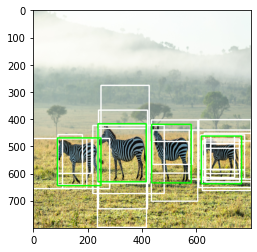

In [88]:
# display RoI samples with positive

img_clone = np.copy(img)

for i in range(pos_roi_per_this_image):
  x1, y1, x2, y2 = roi[pos_index[i]].astype(int)
  cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255,255,255),
                thickness=3)
  
for i in range(len(bbox)):
  cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), 
                color = (0, 255, 0), thickness=3)

plt.imshow(img_clone)
plt.show()

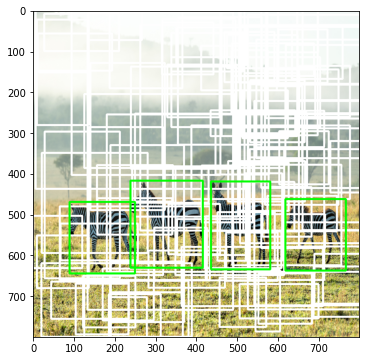

In [89]:
# display RoI samples with negative

img_clone = np.copy(img)

plt.figure(figsize=(9, 6))

for i in range(neg_roi_per_this_image):
  x1, y1, x2, y2 = roi[neg_index[i]].astype(int)
  cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255, 255, 255),
                thickness=3)
  
for i in range(len(bbox)):
  cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), 
                color = (0, 255, 0), thickness=3)
  
plt.imshow(img_clone)
plt.show()

- 위의 그림에서 초록색 box는 ground-truth box, 흰색 box는 predicted bounding box이다.
- 1번째 그림은 positive sample에 해당하는 box를, 2번째 그림은 negative sample에 해당하는 box를 시각화한 결과이다. 1번째 그림에서는 얼룩말의 위치를 상대적으로 잘 맞춘 반면, 오른쪽 그림에서는 다수의 box가 배경을 포함하고 있는 모습을 확인할 수 있다.

#### 5) Gather positive/negative samples

In [90]:
# now we gather positive samples index and negative samples index
# their respective labels and region proposals

keep_index = np.append(pos_index, neg_index)
gt_roi_labels = gt_roi_label[keep_index]
gt_roi_labels[pos_roi_per_this_image:] = 0 # negative labels => 0
sample_roi = roi[keep_index]
print(sample_roi.shape)

(128, 4)


In [91]:
# pick the ground truth objects for these sample_roi and
# later parameterized as we have done while assigning locations to 
# anchor boxes

bbox_for_sampled_roi = bbox[gt_assignment[keep_index]]
print(bbox_for_sampled_roi.shape)

(128, 4)


In [92]:
width = sample_roi[:, 2] - sample_roi[:, 0]
height = sample_roi[:, 3] - sample_roi[:, 1]
ctr_x = sample_roi[:, 0] + 0.5 * width
ctr_y = sample_roi[:, 1] + 0.5 * height

base_width = bbox_for_sampled_roi[:, 2] - bbox_for_sampled_roi[:, 0]
base_height = bbox_for_sampled_roi[:, 3] - bbox_for_sampled_roi[:, 1]
base_ctr_x = bbox_for_sampled_roi[:, 0] + 0.5 * base_width
base_ctr_y = bbox_for_sampled_roi[:, 1] + 0.5 * base_height 

In [93]:
# transform anchor boxes

eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dx = (base_ctr_x - ctr_x) / width
dy = (base_ctr_y - ctr_y) / height
dw = np.log(base_width / width)
dh = np.log(base_height / height)

gt_roi_locs = np.vstack((dx, dy, dw, dh)).transpose()
print(gt_roi_locs.shape)

(128, 4)


### 7. RoI pooling

- Feature extractor를 통해 얻은 feature map과 Proposal Target layer에서 추출한 region proposals을 활용하여 RoI pooling을 수행
- 이 때 output feature map의 크기가 7x7이 되도록 설정 

#### 1) Concatenate labels with bbox coordinates

In [94]:
# Take out the features of 128 ROI samples and 
# use max pooling to adjust to the same size, H=7, W=7 (ROI Pooling)

rois = torch.from_numpy(sample_roi).float()
roi_indices = 0 * np.ones((len(rois),), dtype=np.int32)
roi_indices = torch.from_numpy(roi_indices).float()
print(rois.shape, roi_indices.shape)

torch.Size([128, 4]) torch.Size([128])


In [95]:
indices_and_rois = torch.cat([roi_indices[:, None], rois], dim=1)
xy_indices_and_rois = indices_and_rois[:, [0, 2, 1, 4, 3]]
indices_and_rois = xy_indices_and_rois.contiguous()
print(xy_indices_and_rois.shape)

torch.Size([128, 5])


#### 2) Rol pooling

In [96]:
size = (7, 7)
adaptive_max_pool = nn.AdaptiveMaxPool2d(size[0], size[1])

In [97]:
output = []
rois = indices_and_rois.data.float()
rois[:, 1:].mul_(1/16.0) # sub-sampling ratio
rois = rois.long()
num_rois = rois.size(0)

for i in range(num_rois):
  roi = rois[i]
  im_idx = roi[0]
  im = output_map.narrow(0, im_idx, 1)[..., roi[1]:(roi[3]+1), roi[2]:(roi[4]+1)]
  tmp = adaptive_max_pool(im)
  output.append(tmp[0])

output = torch.cat(output, 0)

print(output.size())

torch.Size([128, 512, 7, 7])


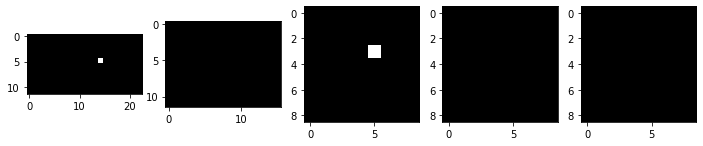

In [98]:
# Visualize the first 5 ROI's feature map (for each feature map, only show the 1st channel of d=512)
fig=plt.figure(figsize=(12, 4))
figNo = 1
for i in range(5):
    roi = rois[i]
    im_idx = roi[0]
    im = output_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
    tmp = im[0][0].detach().cpu().numpy()
    fig.add_subplot(1, 5, figNo) 
    plt.imshow(tmp, cmap='gray')
    
    figNo +=1
plt.show()

In [99]:
# Reshape the tensor so that we can pass it through the feed forward layer.
k = output.view(output.size(0), -1)
print(k.shape) # 25088 = 7*7*512

torch.Size([128, 25088])


### 8. Fast R-CNN

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2F84O0e%2FbtqRcGXvEdY%2FK0HeKRk6M1Nvk8wmBFylF0%2Fimg.png" width=600>

- RoI pooling을 통해 얻은 7x7 크기의 feature map을 입력받을 fc layer를 정의한다(첫 fc layer의 크기는 25088(7x7x512) x 4096)
- class별로 bounding box coefficients를 예측하는 Bounding box regresor와 clas score를 예측하는 Classifier를 정의한다. Multi-task를 구하는 부분은 RPN과 비슷하기에 생략했다.

#### 1) Classifier and Bounding box regressor

In [105]:
# 128 boxes + features (7x7x512) of ROI samples are sent to 
# Detection network to predict the objects bounding box and clas of the input image

roi_head_classifier = nn.Sequential(*[nn.Linear(25088, 4096), nn.Linear(4096, 4096)]).to(device)
cls_loc = nn.Linear(4096, 2 * 4).to(device) # 1 class, 1 background, 4 coordiinates
cls_loc.weight.data.normal_(0, 0.01)
cls_loc.bias.data.zero_()

score = nn.Linear(4096, 2).to(device) # 1 class, 1 background

In [107]:
# passing the output of roi pooling to RoI head

k = roi_head_classifier(k.to(device))
roi_cls_loc = cls_loc(k)
roi_cls_score = score(k)

print(roi_cls_loc.shape, roi_cls_score.shape)

torch.Size([128, 8]) torch.Size([128, 2])


In [108]:
# Calculate the loss of Fast RCNN based on the gt bboxes and features (h, w, d=512) 
# corresponding to these 128 ROIs

# predicted
print(roi_cls_loc.shape)
print(roi_cls_score.shape)

#actual
print(gt_roi_locs.shape)
print(gt_roi_labels.shape)

torch.Size([128, 8])
torch.Size([128, 2])
(128, 4)
(128,)


In [109]:
gt_roi_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

#### 2) Classification loss


In [110]:
# Converting ground truth to torch variable
gt_roi_loc = torch.from_numpy(gt_roi_locs)
gt_roi_label = torch.from_numpy(np.float32(gt_roi_labels)).long()
print(gt_roi_loc.shape, gt_roi_label.shape)

#Classification loss
roi_cls_loss = F.cross_entropy(roi_cls_score.cpu(), gt_roi_label.cpu(), ignore_index=-1)

torch.Size([128, 4]) torch.Size([128])


#### 3) Regression loss


In [111]:
# regression loss

n_sample = roi_cls_loc.shape[0]
roi_loc = roi_cls_loc.view(n_sample, -1, 4)
print(roi_loc.shape)

torch.Size([128, 2, 4])


In [112]:
roi_loc = roi_loc[torch.arange(0, n_sample).long(), gt_roi_label]
print(roi_loc.shape)

torch.Size([128, 4])


In [113]:
# for regression we use smooth l1 loss as defined in the Fast R-CNN paper
pos = gt_roi_label > 0
mask = pos.unsqueeze(1).expand_as(roi_loc)
print(mask.shape)

torch.Size([128, 4])


In [114]:
# take those bounding boxes which have positive labels
mask_loc_preds = roi_loc[mask].view(-1, 4)
mask_loc_targets = gt_roi_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
roi_loc_loss = ((x < 1).float() * 0.5 * x ** 2) + ((x >= 1).float() * (x - 0.5))
print(roi_loc_loss.sum())

torch.Size([21, 4]) torch.Size([21, 4])
tensor(4.5924, dtype=torch.float64, grad_fn=<SumBackward0>)


#### 4) Multi-task loss


In [119]:
roi_lambda = 10.
roi_loss = roi_cls_loss + (roi_lambda * roi_loc_loss)
roi_loss = roi_loss.to(device)  # GPU 상에 있는 rpn_loss와 더하기 연산을 하려면, roi_loss도 동일하게 GPU 상에 있어야 함
print(roi_loss)

total_loss = rpn_loss + roi_loss
print(total_loss)

tensor([[0.7586, 4.1523, 0.7495, 3.4044],
        [1.2039, 1.0289, 1.1485, 1.3084],
        [0.7855, 0.7332, 1.2449, 0.7313],
        [0.7867, 1.5675, 0.9075, 1.9242],
        [0.9075, 1.3751, 1.2232, 1.0998],
        [1.0580, 0.8004, 1.3763, 0.8674],
        [0.8722, 1.6971, 0.9194, 1.6607],
        [0.7617, 0.7368, 0.7475, 1.2865],
        [0.7733, 1.8138, 1.3599, 0.8764],
        [0.9087, 0.8852, 1.2967, 2.4010],
        [1.3857, 0.7359, 3.1526, 0.7419],
        [0.8047, 1.2066, 2.9289, 0.8541],
        [0.7364, 1.0517, 0.9459, 0.8083],
        [0.9674, 0.7467, 0.7533, 0.7522],
        [0.8976, 0.8040, 1.3463, 1.0613],
        [0.7601, 1.7265, 2.5567, 0.8523],
        [0.8408, 1.0327, 0.9835, 1.5611],
        [0.7611, 0.8236, 2.9370, 0.9192],
        [0.9258, 1.8549, 0.7892, 1.4270],
        [0.9787, 1.8901, 2.6166, 1.1830],
        [0.7589, 1.1382, 2.6929, 2.5213]], device='cuda:0',
       dtype=torch.float64, grad_fn=<ToCopyBackward0>)
tensor([[4.8542, 8.2479, 4.8451, 7.5000],
   

-- 끝. --